In [1]:
# import gym
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from IPython.display import clear_output
from matplotlib import pyplot as plt

from timeit import default_timer as timer
from datetime import timedelta

import math
import random

from qutip import Bloch, Bloch3d, basis
from qutip.qip.operations import rz

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
def plot(axs, frame_idx, losses, sigma, mu, elapsed_time, contextual_bias=None, rewards=None):
    if rewards:
        axs[0].set_title('frame %s. reward: %s. time: %s' % (frame_idx, np.mean(rewards[-10:]), elapsed_time))
        axs[0].plot(rewards)
    if losses and sigma:
        axs[1].set_title('fidelity')
        axs[1].plot(losses, 'g')
        axs[1].plot(sigma, 'r')
    if contextual_bias:
        axs[2].set_title('contextual_bias')
        axs[2].plot(contextual_bias)
        axs[2].axhline(y=mu, color='g', linestyle='-')

In [4]:
# (action, reward) distribution for a given "spectator measurement outcome" state
class Context:
    def __init__(self, gamma, eta):
        # discount factor
        self.gamma = gamma
        self.eta = eta

        self.batch_correction_feedback = ([], [], [])
        self.correction_theta = [0, 0, 0]

    def reset(self):
        self.batch_correction_feedback = ([], [], [])

    def discount(self):
        pass

    def update_gamma(self, gamma):
        self.gamma = gamma

    def update_batch_feedback(self, correction_feedback, idx):
        self.batch_correction_feedback[idx].append(correction_feedback)

    def get_and_combine_optimal_theta(self):
        if len(self.batch_correction_feedback[0]) == 0:
            return self.correction_theta

        # feedback is given per theta
        for idx, f in enumerate(self.batch_correction_feedback):
            lo = [r[0] for r in f]
            mid = [r[1] for r in f]
            hi = [r[2] for r in f]
            
            mu_plus = np.mean(hi)
            mu_minus = np.mean(lo)

            grad = mu_plus - mu_minus

            self.correction_theta[idx] -= self.eta * grad
        
        self.reset()
        
        return self.correction_theta

    def get_optimal_theta(self):
        return self.correction_theta

In [5]:
# contextual analytic geometric descent
class Analytic2D:
    def __init__(self, env, initial_gamma=0.99, eta=np.pi/64):
        # two contexts -> pos vs neg rotation with respect to a chosen rotational basis
        self.contexts = [Context(initial_gamma, eta), Context(initial_gamma, eta)]

        self.rewards = []
        self.fidelity = []
        self.control_fidelity = []

        self.num_context_spectators = env.num_context_spectators
        self.num_reward_spectators = env.num_reward_spectators

        # step size
        self.eta = eta
        
        self.batch_context_feedback = ([], [], [])
        self.context_theta = [0, 0, 0]

    def get_actions(self, observations):
        # our context is an array of binary spectator qubit measurements
        # hence, we could convert this binary array to an integer and index 2^(spectator qubits) contexts
        # context = self.contexts[np.packbits(observation, bitorder='little')[0]] 
        # for now, we only have two contexts (+ vs -), and so we consider spectators to be indistinguishable noise polling devices
        # in the future, we may consider noise gradients and so we do indeed need to track the specific arrangement

        actions = []
        for observation in observations:
            context_idx = 1 if np.sum(observation) > self.num_context_spectators / 2 else 0
            context = self.contexts[context_idx]

            # (theta vec)
            
            if len(self.batch_context_feedback[0]) != 0:
                for idx, f in enumerate(self.batch_context_feedback):
                    lo = [r[0] for r in f]
                    mid = [r[1] for r in f]
                    hi = [r[2] for r in f]

                    mu = np.mean(mid)
                    var_grad = np.mean([2 * (m - mu)  * (h - l) for l, m, h in zip(lo,mid,hi)])

                    self.context_theta[idx] -= self.eta * var_grad
                self.batch_context_feedback = ([], [], [])
            
            actions.append((context.get_and_combine_optimal_theta(), self.context_theta))
        return actions

    def update(self, context_feedback, correction_feedback, observations):
        for context in self.contexts:
            context.reset()
        
        # feedback is given per theta
        for idx in range(len(self.context_theta)):
            for _context_feedback, _correction_feedback, observation in zip(context_feedback[idx], correction_feedback[idx], observations):
                context_idx = 1 if np.sum(observation) > self.num_context_spectators / 2 else 0
                context = self.contexts[context_idx]
                context.update_batch_feedback(_correction_feedback, idx)
            
                self.batch_context_feedback[idx].append(_context_feedback)

    def _update_gammas(self, gamma):
        for context in self.contexts:
            context.update_gamma(gamma)

    def save_reward(self, reward):
        self.rewards.append(reward)

    def save_fidelity(self, fidelity):
        self.fidelity.append(fidelity)

    def save_control_fidelity(self, fidelity):
        self.control_fidelity.append(fidelity)

In [6]:
M = 1000
BATCH_SIZE = 100

MU = np.pi / 8
SIGMA = np.pi / 4

# add some random harmonics
# time_dependent_fn = np.vectorize(lambda x: (2/5) * np.pi * np.sin(2 * np.pi * x / M))
error_samples = np.random.normal(MU, SIGMA, M) # + time_dependent_fn(np.arange(M))
# error_samples = np.random.choice([-np.pi/4, np.pi / 4], M)

In [7]:
from spectator_env import SpectatorEnvContinuousV2

# describes MDP
# - states are given in terms of a #context_spectators bit measurement outcomes
# - continuous action space is given by ([-pi, pi], smoothing parameter, contextual_measurement_bias) i.e. \U(1) \times U(1) \times U(1)
env = SpectatorEnvContinuousV2(error_samples, batch_size=BATCH_SIZE, num_context_spectators=64, num_reward_spectators=64, context_sensitivity=1.0, reward_sensitivity=1.0)


In [8]:
from qutip.operators import sigmax, sigmay, sigmaz
from qutip import basis

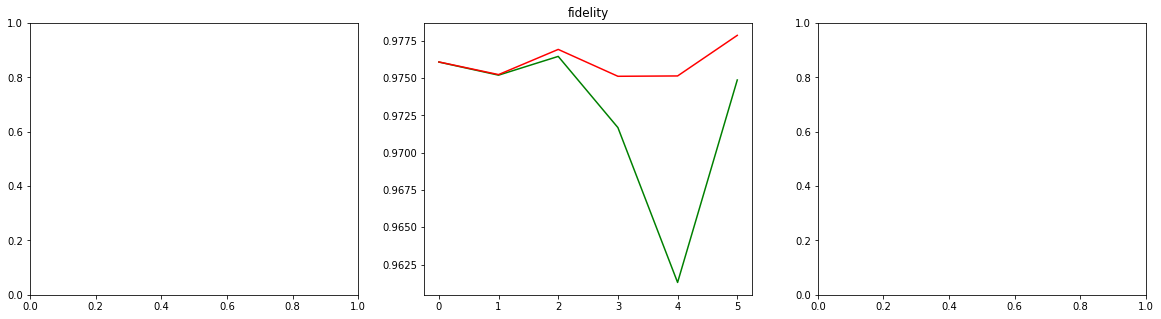

[-1.934694324783512, -2.145350997645326, -0.9535822063014028]
0.7635396287849386
[[-0.05141010440515993, 0.04467930817276938, 0.05234803640287988], [0.06218696541920578, -0.07998040051607525, -0.07351600176475383]]


In [ ]:
start = timer()

md = Analytic2D(env, initial_gamma=1.0, eta=np.pi/8)

episode_fidelity = []
control_fidelity = []

MAX_FRAMES = 10 * M // BATCH_SIZE
UPDATE_ERROR_SAMPLES_FRAMES = M // BATCH_SIZE

# "episodes" are a reasonable way to think about learning a periodic time dependent function
# max frames = episode length * num episodes
# episodes are identical sequences of training data
observation = env.reset()
print(observation.shape)

for frame_idx in range(1, MAX_FRAMES + 1):
    actions = md.get_actions(observation)
    prev_batch = env.error_samples_batch
    prev_observation = observation
    observation, feedback, done, info = env.step(actions)
    context_feedback, correction_feedback = feedback
    observation = None if done else observation

    # generally, in RL we would consider r(s | s', a)
    # given a state transition s' -> s due to action a
    # for now, we are only interested in r(s', a)
    md.update(context_feedback, correction_feedback, prev_observation)

    for x, y in info:
        episode_fidelity.append(x)
        control_fidelity.append(y)

    if UPDATE_ERROR_SAMPLES_FRAMES:
        new_error_samples = np.random.normal(MU, SIGMA, M)
        env.set_error_samples(new_error_samples)

    if done:
        md.save_fidelity(np.mean(episode_fidelity))
        md.save_control_fidelity(np.mean(control_fidelity))
        episode_fidelity = []
        control_fidelity = []
        
        observation = env.reset()

        clear_output(True)
        fig, axs = plt.subplots(1, 3, figsize=(20,5))
        plot(axs, frame_idx, md.fidelity, md.control_fidelity, -MU,
            timedelta(seconds=int(timer()-start)))
        plt.show()
        
        print(md.context_theta)
        g1 = 1j * md.context_theta[0] * sigmay()
        g2 = 1j * md.context_theta[1] * sigmax()
        g3 = 1j * md.context_theta[2] * sigmay()
        print(
            np.abs(((g3.expm() * g2.expm() * g1.expm()).dag() * sigmax() * basis(2, 0)).overlap(sigmay() * basis(2, 0))) ** 2
        )
        
        print([c.correction_theta for c in md.contexts])

env.close()

